#### Overview of the dataset


NLP is Natural Language Processing where the machine is made to understand the natural language and work on it, it could be generating responses to a prompt or identifying spam messages or like in this case, identifying topics of news articles.  

The models used in this report for NLP are LDA(Latent Dirichlet allocation) and Agglomerative Hierarchial clustering. 

There are different ways in which we can feed the words to the machine, but in this report we will be converting the words to an array of vectors where each word will be represented by the number of it's occurance.  

- The dataset is a CSV with tab-separated news articles.   
- The problem statement is to wrangle the data properly and identify groups to which the articles can be assigned to. That is the topic of the news.   
- It is an usupervised machine learning task since there are no target variables.


In [ ]:
import numpy as np # Library for performing numerical tasks
import pandas as pd # Library for dataset wrangling 
import matplotlib.pyplot as plt # Library for plotting
import seaborn as sns # Library for plotting

from sklearn.pipeline import Pipeline # To create separate pipelines for ease of execution

from sklearn.preprocessing import StandardScaler # For Scaling the data

# For Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 


# For Splitting the data into train/test or train/test/validation sets
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


from sklearn.feature_selection import RFE # For Recursive Feature Elimination

# Performance Metrics for Model Evaluation
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Libraries specific for Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


# Libraries specific for Regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer

# Libraries specific for NLP
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import silhouette_score 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans # Clustering
from sklearn.decomposition import LatentDirichletAllocation  # LDA
from sklearn.preprocessing import MaxAbsScaler 


import warnings
warnings.filterwarnings("ignore") 

### EDA - NLP

#### 1. Importing the dataset

In [55]:
news_data = pd.read_csv('news.csv', sep='\t')
news_data.head()

,story
0,Quarterly profits at US media giant TimeWarner...
1,The dollar has hit its highest level against t...
2,The owners of embattled Russian oil giant Yuko...
3,British Airways has blamed high fuel prices fo...
4,Shares in UK drinks and food firm Allied Domec...


#### 2. Checking for any null values

In [56]:
news_data.isnull().sum()

story    0
dtype: int64

#### 3. Preprocessing the data

In [57]:
len(news_data['story']) # No. of articles

2225

In [58]:
cleaned_data = []

for i in range(0, len(news_data['story'])):
    article = re.sub('[^a-zA-Z]',' ',news_data['story'][i])   # Replace everything except letters to space
    article = article.lower()                                 # Convert all capital to lower case
    article = article.split()                                 # Split the sentences into separate words
    
    #Stemming
    port_stem = PorterStemmer()
    article = [port_stem.stem(word) for word in article if not word in set(stopwords.words('english'))] # avoiding stopwords
    article = ' '.join(article)
    cleaned_data.append(article)

In [59]:
len(cleaned_data) # Making sure no. of articles hasn't changed

2225

#### 4. Creating Vector of words 

Words have to be converted to vectors in order to be fed to the NLP model.

In [60]:
# Using CountVectorizer - For KMeans and LDA
vectorizer = CountVectorizer(max_features=20000, stop_words='english')  
count_vector_articles = vectorizer.fit_transform(cleaned_data)

In [61]:
# Using TF-IDF - For Agglomerative Clustering
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english') 
tf_idf_articles = tfidf_vectorizer.fit_transform(cleaned_data)

### PIPELINE 1 - Kmeans (With and Without Scaling) and LDA

Clusters: 2, Silhouette Score: 0.1604
Clusters: 3, Silhouette Score: 0.1283
Clusters: 4, Silhouette Score: 0.0536
Clusters: 5, Silhouette Score: 0.0724
Clusters: 6, Silhouette Score: 0.0729
Clusters: 7, Silhouette Score: 0.1189
Clusters: 8, Silhouette Score: 0.0356
Clusters: 9, Silhouette Score: 0.0405
Clusters: 10, Silhouette Score: 0.0379
Clusters: 11, Silhouette Score: 0.0674
Clusters: 12, Silhouette Score: 0.0701
Clusters: 13, Silhouette Score: 0.0106
Clusters: 14, Silhouette Score: 0.0113
Clusters: 15, Silhouette Score: 0.0120
Clusters: 16, Silhouette Score: 0.0091
Clusters: 17, Silhouette Score: 0.0126
Clusters: 18, Silhouette Score: 0.0125
Clusters: 19, Silhouette Score: 0.0133
Clusters: 20, Silhouette Score: 0.0137
Clusters: 21, Silhouette Score: 0.0112
Clusters: 22, Silhouette Score: 0.0104
Clusters: 23, Silhouette Score: 0.0141
Clusters: 24, Silhouette Score: 0.0106
Clusters: 25, Silhouette Score: 0.0107
Clusters: 26, Silhouette Score: 0.0124
Clusters: 27, Silhouette Score: 0

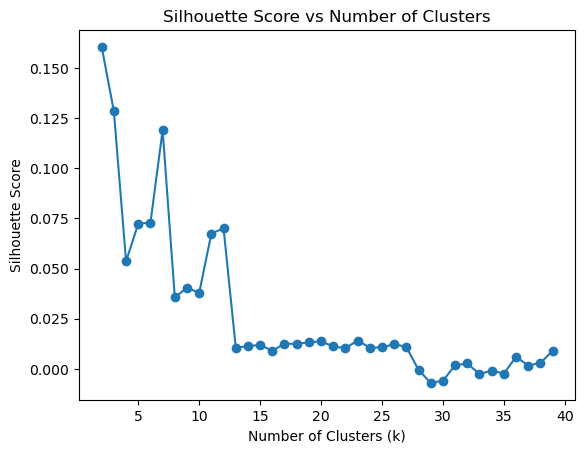

In [62]:
cluster_range = range(2, 40)  
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=26)
    kmeans.fit(count_vector_articles)
    score = silhouette_score(count_vector_articles, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

# Plot silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


#### Observation

- Silhouette score obtained is not ideal 
- A good silhouette score should be close to +1 for the clusters to be well defined
- Silhouette score for 7 seems like the okay option from this graph, since taking 2 or 3 clusters would be too less.

##### Scaling the vector

In [63]:
max_abs_scaler = MaxAbsScaler()
count_vector_articles_scaled = max_abs_scaler.fit_transform(count_vector_articles)

Clusters: 2, Silhouette Score: 0.0503
Clusters: 3, Silhouette Score: 0.0513
Clusters: 4, Silhouette Score: -0.0133
Clusters: 5, Silhouette Score: -0.0131
Clusters: 6, Silhouette Score: -0.0130
Clusters: 7, Silhouette Score: -0.0129
Clusters: 8, Silhouette Score: -0.0126
Clusters: 9, Silhouette Score: -0.0056
Clusters: 10, Silhouette Score: -0.0339
Clusters: 11, Silhouette Score: -0.0339
Clusters: 12, Silhouette Score: -0.0331
Clusters: 13, Silhouette Score: -0.0321
Clusters: 14, Silhouette Score: -0.0319
Clusters: 15, Silhouette Score: -0.0318
Clusters: 16, Silhouette Score: -0.0316
Clusters: 17, Silhouette Score: -0.0304
Clusters: 18, Silhouette Score: -0.0293
Clusters: 19, Silhouette Score: -0.0293
Clusters: 20, Silhouette Score: -0.0281
Clusters: 21, Silhouette Score: -0.1196
Clusters: 22, Silhouette Score: -0.1195
Clusters: 23, Silhouette Score: -0.1184
Clusters: 24, Silhouette Score: -0.1182
Clusters: 25, Silhouette Score: -0.1180
Clusters: 26, Silhouette Score: -0.1179
Clusters: 

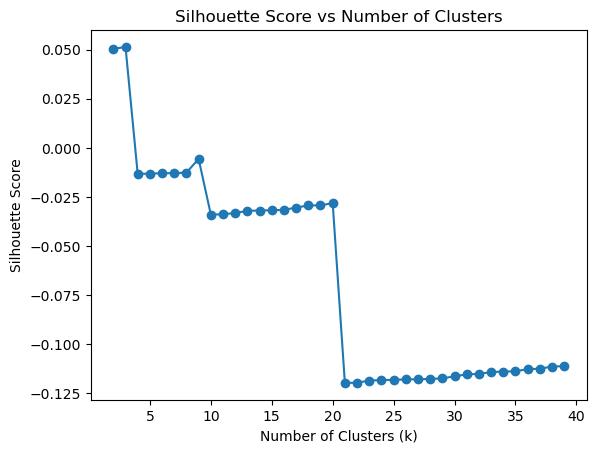

In [64]:
cluster_range = range(2, 40)  
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=26)
    kmeans.fit(count_vector_articles_scaled)
    score = silhouette_score(count_vector_articles_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

# Plot silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


- Scaling the data has made the silhouette score worse. With both scaled and unscaled data, KMeans does not seem like a good algorithm based on the silhouette score.

#### LDA

- LDA is a topic modeling algorithm which can identify topics from a collection of documents.   
- It can be used for our use case of unsupervised machine learning because we do not have a target variable like in classification.

In [65]:
# Hyperparameters for LDA
param_dist = {
    'n_components': [5,6,7,8,9,10],  # Number of clusters to evaluate
    'max_iter': [5,10],  # Number of iterations
}

# Creating the LDA model
lda = LatentDirichletAllocation(random_state=26)

# Performing RandomizedSearchCV to find the best hyperparameters
randomized_search = RandomizedSearchCV(lda, param_distributions=param_dist, 
                                       n_iter=4, cv=3, n_jobs=-1, random_state=26, verbose=1)

# Fitting the data to randomized search (used instead of Grid search to reduce computation)
randomized_search.fit(count_vector_articles)

# Getting the best model after Randomized Search
best_lda = randomized_search.best_estimator_

# Best Hyperparameters
print(f"Best Hyperparameters: {randomized_search.best_params_}")

# Extracting the top words for each topic  
terms = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(best_lda.components_):        
    print(f"Topic {topic_idx}:")                                # Topic Number
    print(", ".join([terms[i] for i in topic.argsort()[-15:]])) # Most important words for the topic

# Getting topic distribution for each article
topic_distributions = best_lda.transform(count_vector_articles)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Hyperparameters: {'n_components': 6, 'max_iter': 10}
Topic 0:
half, second, open, team, club, final, match, time, england, player, year, win, game, play, said
Topic 1:
rise, month, expect, economi, share, rate, bank, compani, growth, sale, price, market, bn, year, said
Topic 2:
uk, make, tv, new, award, film, technolog, phone, mobil, best, use, year, peopl, music, said
Topic 3:
year, tax, tori, new, blair, plan, minist, peopl, parti, labour, elect, say, govern, mr, said
Topic 4:
like, day, olymp, releas, record, titl, new, play, star, time, world, year, said, film, game
Topic 5:
inform, new, mani, mail, file, secur, user, softwar, site, peopl, mr, use, firm, compani, said


#### Observation

- Based off the silhouette score from K-Means, we had chosen numbers around and including 7 for n_components
- The LDA model using hyperparameter tuning has determined that having 6 categories has given the best result 
- Based on the top words for each topic, we can assume the following categories for the news_articles:  
 
    - Topic 0 - Sports  
    - Topic 1 - Economy  
    - Topic 2 - Entertainment  
    - Topic 3 - Government
    - Topic 4 - Awards  
    - Topic 5 - Information Technology  

### PIPELINE 2 - Agglomerative Clustering

- Agglomerative Clustering is one of the unsupervised machine learning algorithms used for Clustering which uses distance metrics like KMeans.  
- It is a hierarchial clustering technique which merges smaller clusters continously till we get the final cluster.  
- It is up to us to cut the tree where the clusters are well defined.  

Best Silhouette Score: 0.014997026309047512
Best Parameters: {'n_clusters': 8, 'linkage_method': 'ward', 'metric': 'euclidean'}


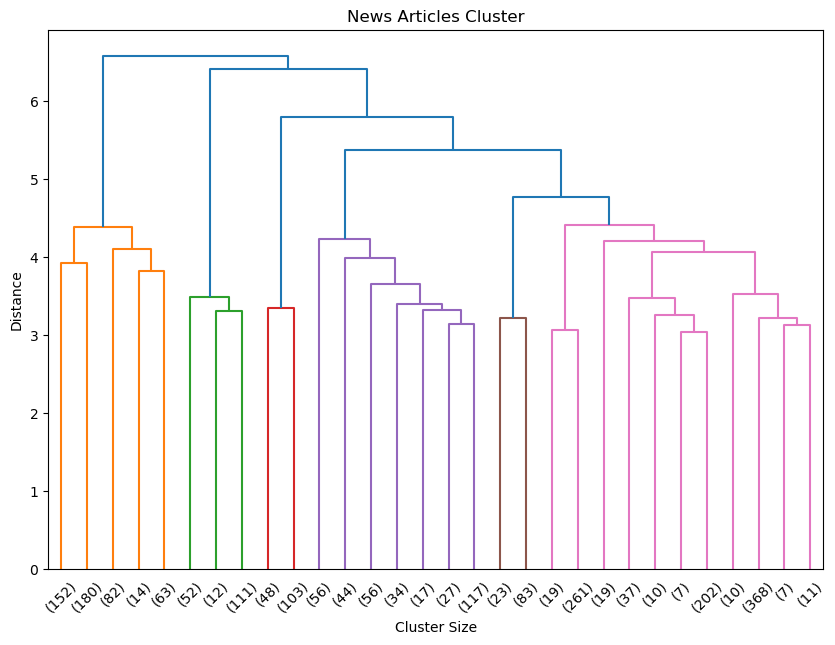


Cluster 0:
112    european commiss written mobil phone oper voda...
210    consum electron giant hitachi matshushita elec...
233    vodafon draft uk chief execut william morrow t...
242    mission brighten work live continu time take l...
251    bt move pre empt possibl break busi offer cut ...
Name: news_article, dtype: object

Cluster 1:
0    quarterli profit us media giant timewarn jump ...
2    owner embattl russian oil giant yuko ask buyer...
3    british airway blame high fuel price drop prof...
4    share uk drink food firm alli domecq risen spe...
7    india attend g meet seven lead industrialis na...
Name: news_article, dtype: object

Cluster 2:
105    chancellor gordon brown meet golden econom rul...
153    chancellor gordon brown given bn boost attempt...
194    uk govern rais tax rein spend want avoid break...
486    busi polit leader around globe arriv swiss mou...
503    climat chang fight aid lead list concern first...
Name: news_article, dtype: object

Cluster 3:
192  

In [67]:
# Hyperparameters for Agglomerative clustering
hyper_parameters = {
    'n_clusters': [4, 5, 6, 7, 8],                                # Number of clusters to evaluate
    'linkage_method': ['ward', 'complete', 'average', 'single'],  # Linkage criteria
    'metric': ['euclidean', 'manhattan', 'cosine']                # Distance metrics
}

# Creating a function for Agglomerative Clustering
def agglomerative_clustering(X, n_clusters, linkage_method, metric):
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters, linkage=linkage_method, metric=metric
    )
    labels = clustering.fit_predict(X)
    score = silhouette_score(X, labels)
    return score, labels

# Grid Search for best parameters 
best_score = -1
best_parameters = None
best_labels = None

for n_clusters in hyper_parameters['n_clusters']:
    for linkage_method in hyper_parameters['linkage_method']:
        for metric in hyper_parameters['metric']:
            # Ward linkage needs euclidean distance
            if linkage_method == 'ward' and metric != 'euclidean':
                continue
            try:
                score, labels = agglomerative_clustering(
                    tf_idf_articles.toarray(), n_clusters, linkage_method, metric
                )
                if score > best_score:
                    best_score = score
                    best_parameters = {
                        'n_clusters': n_clusters,
                        'linkage_method': linkage_method,
                        'metric': metric
                    }
                    best_labels = labels
            except Exception as e:
                print(f"Error for {n_clusters}, {linkage_method}, {metric}: {e}")

print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_parameters}")

# Drawing the dendogram for the clustering
plt.figure(figsize=(10, 7))
diagram = linkage(tf_idf_articles.toarray(), method=best_parameters['linkage_method'], metric=best_parameters['metric'])
dendrogram(diagram, truncate_mode='lastp', p=30)
plt.title("News Articles Cluster")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()


final_news_labels = pd.DataFrame({'news_article': cleaned_data})  # Assigning cluster label to each news article
final_news_labels['cluster'] = best_labels


for cluster_id in range(best_parameters['n_clusters']): # For each cluster
    print(f"\nCluster {cluster_id}:")
    print(final_news_labels[final_news_labels['cluster'] == cluster_id]['news_article'].head())  # printing the top 5 articles

##### Observation

- Based on the news articles of each cluster, we can label them as follows:  
    - **Cluster 0: Electronics and Communication**       (because of keywords like vodafone and mobile operators)
    - **Cluster 1: World Economy**      (because of US, Russia, UK, India and economy related words like profit, price, industrialists )
    - **Cluster 2: World Politics and Business**     ( Chancellor Gordon Brown, Business politics leaders around globe, climate change fight aid)
    - **Cluster 3: Footbal(Soccer)**     (football club, arsenal, borussia dortmund, sunderland fc)
    - **Cluster 4: Sports**      (hurdler, athlete, pole vaulter, olympic title)
    - **Cluster 5: World Finance**     (Japan economy, dollar, europe largest economy, french economy...)
    - **Cluster 6: Consumer**     (cheese, mcdonald, music giant, mobile phone)
    - **Cluster 7: Entertainment**     (actor, harry potter, walt disney, internet bestseller)


- Silhouette score is still low   
- Clusters are not as well defined since some articles feel like they could be grouped together in the same cluster.   
- There also seems to be misclassification like in Cluster 3, it feels like all the articles are about football clubs and there is an odd entry about Johnson and Johnson which has nothing to do with football.



### RESULT - NLP

- Comparing the clusters of both LDA and Agglomerative Clustering:  
    - The clusters of LDA are more defined and do not have overlaps of news articles
    - The clusters of Agglomerative Clustering have more overlap of news articles and there were clusters which could be grouped together like World finance and World Economy.
    
- The silhouette scores of KMeans and Agglomerative clustering are very low  
- Based on the clusters produced, **LDA is the best option**.  
- Results maybe can be improved further by different pre-processing techniques or using complex models like CNN( Convolutional Neural Networks).